# Károly Dániel Kecse's final project for Machine Learning Supervised Technique Labor assignment
## Neptune code: BWQ1BU

Project description: 
Brain tumor is a very serious problem (aswell as any other cancer). Proper treatment, planning, and accurate diagnostics should be implemented to improve the life expectancy of the patients. With the help of X-Ray images, we can apply Machine Learning solutions, such as CNN, Artificial Neural Networks and Transfer Learning to try to classify and recognise these diseases as soon as possible. This is an especially hard task for developing or third world countries, where the number of skilled, experienced doctors is very limited. An automated system could solve this rather challenging, time and resource intensive problem.

The following types of tumors can be found inside this dataset:
- ### ***Glioma tumor***:
    - **Location**: Can be found anywhere in the brain.
    - **Appearance on MRI**: Irregular shapes often seen within the brain tissue. They might be central or spread across different areas.
    - **Effects/Detectability**: Symptoms vary but may include headaches, seizures, or personality changes. Detectable on MRI due to abnormal shapes and growth patterns.
    
- ### ***Meningioma tumor***: 
    - **Location**: Typically near the surface of the brain, attached to the meninges.
    - **Appearance on MRI**: Often appear as rounded or lobulated masses, usually distinct from the surrounding brain tissue.
    - **Effects/Detectability**: Can cause symptoms based on location, such as headaches or vision changes. Detectable on MRI due to well-defined shapes and contrast with surrounding brain tissue.
    
- ### ***Pituitary tumor***: 
    - **Location**: Located at the base of the brain within the pituitary gland.
    - **Appearance on MRI**: Usually small and round, often seen near the center of the brain, close to the optic nerves.
    - **Effects/Detectability**: May cause hormonal imbalances leading to symptoms like changes in growth or metabolism. Detectable on MRI due to its position and impact on nearby structures.
    
- ### ***Healthy brain (no tumor)***:
    - **Location**: Images from various parts of the brain without any abnormal growth.
    - **Appearance on MRI**: Smooth and uniform brain tissue without irregular masses or growths.
    - **Effects/Detectability**: No symptoms related to tumors. MRI scans show a consistent and healthy brain structure without abnormalities.

In [1]:
import numpy as np
import os
import cv2
import matplotlib.pyplot as plt
import tensorflow as tf
import seaborn as sns

from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

from tensorflow.keras.utils import to_categorical

from tensorflow.keras.applications import EfficientNetB3
from tensorflow.keras.applications.efficientnet import preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from tensorflow.keras import layers
from tensorflow.keras.models import Sequential, Model
from keras.layers import Flatten, Dropout, Dense, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler

from sklearn.metrics import classification_report,confusion_matrix

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


# About the folders/dataset

The Dataset consists of Training and Testist folders. 
In the Training folder, each class has ~820-825 images, except for the **no_tumor** class, which only has 395 images, so the training dataset is rather imbalanced. However, the results have shown that the model is still capable of the classification for all 4 classes.
The Testing folder contains around 100 images for each classes.

Because of the lack of a Validation folder, I have created a collection of both the Training and Testing images, then used the train_test_split to create a training, validation and test dataset (train:81%, validation: 9%, test: 10%)

In [2]:
# I have used the kaggle environment since it was way easier than downloading all the images and uploading them later and the GPU 
# available here is way more powerful than the one I have
train_dir = "/kaggle/input/brain-tumor-classification-mri/Training"
test_dir = "/kaggle/input/brain-tumor-classification-mri/Testing"

#Labels: ['glioma_tumor', 'meningioma_tumor', 'no_tumor', 'pituitary_tumor']
labels = os.listdir(train_dir)
labels.sort()

Here, we use the ImageDataGenerator keras function to apply our EfficientNetB3 model's preprocess input and split the training dataset into Train and Validation subsets. It basically handles all the normalization and image transformation we should define during the data processing. It is also useful for data augmentation. Here, I have used non-aggressive transformations in order to keep the MRI picture's main content. I have used slight rotations and zooms.

Then, I have used these generators to read from the directory. I have shuffled the read images. It was essential to use 'categorical' class_mode to read the data to get the read labels as one hot encoded labels. For the subsets I had to specify wether the variable will contain the Training or the Validation part of the split set. The input images will be in (224, 224, 3) shape.

In [ ]:
# With ImageDataGenerator, we split the Training dataset into Training and Validation dataset. Since we have limited 
train_generator = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    validation_split=0.2
)

train_loader = train_generator.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=32,
    shuffle = True,
    class_mode='categorical',
    subset="training"
)

valid_loader = train_generator.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset="validation"
)

Here, we calculate the class distribution. We traverse through every subdirectory of the Training and Testing folders and count how many images are inside them, then assign a random RGB color to the classes, making it easier to understand the plotted chart.

In [ ]:
label_counts = {}
label_colors = {}
for i in labels:
    label_counts[i] = 0
    label_colors[i] = 0

for class_name in os.listdir(train_dir):
    class_path = os.path.join(train_dir, class_name)
   
    file_count = 0
    for filename in os.listdir(class_path):
        file_path = os.path.join(class_path, filename)
        if os.path.isfile(file_path):
            file_count += 1
        
    label_counts[class_name] = file_count
    label_colors[class_name] = np.random.rand(3,)
    
for class_name in os.listdir(test_dir):
    class_path = os.path.join(test_dir, class_name)
   
    file_count = 0
    for filename in os.listdir(class_path):
        file_path = os.path.join(class_path, filename)
        if os.path.isfile(file_path):
            file_count += 1
        
    label_counts[class_name] = label_counts[class_name] + file_count
    
plt.figure(figsize=(10, 6))
bars = plt.bar(labels, label_counts.values(), color=[label_colors[label] for label in labels])

# Display actual values above each bar
for bar, count in zip(bars, label_counts.values()):
    plt.text(bar.get_x() + bar.get_width() / 2 - 0.15, bar.get_height() + 0.05, str(count), fontsize=10)

plt.xlabel('Labels')
plt.ylabel('Count')
plt.title('Distribution of Classes in the Dataset')
plt.show()

### Examples
Here, we can see some images from the validation dataset plotted with their corresponding labels.

In [ ]:
sample_images, sample_labels = next(valid_loader)
sample_images = sample_images / 255.0
# Plot the first 5 images from our dataset
plt.figure(figsize=(15, 3))
for i in range(5):
    plt.subplot(1, 5, i + 1)
    plt.imshow(sample_images[i])
    label_index = int(sample_labels[i].argmax())
    plt.title(labels[label_index])
    plt.axis('off')
plt.show()


In [ ]:
print(f"This batch contains {len(sample_images)} images")
print(f"Image shape: {sample_images[0].shape}")
print(f"Classes: {labels}")

# Training and model

### CNN:
A Convolutional Neural Network (CNN) is a type of deep neural network designed for processing and analyzing visual data. It's particularly powerful in tasks such as image recognition, classification, and object detection. CNN helps to reduce the number of features compared to loading the entire image into a FCNN, hence enabling runs on either training or making new predictions on unseen images.
CNN introduces two new layer concepts:
- **Convolution layer**: this layer is particularly useful at recognizing patterns and relationships between our images aswell as slightly reduce the dimensionality of the images with the help of kernels (this is of course based on wether we apply a padding or not) while having the chance to apply more filters on our current image by specifying the depth of the layer (i.e. the number of filters or kernels in the convolution layer).
- After a convolution layer there is usually an Activation Layer, which is ReLU most of the time.
- **Pooling (Max/Avg) layer**: these layers are really helpful at reducing noise or emphasising the strongest feature visible on a given area of the image. With the help of this layer we can drastically reduce the width and height of the processed image (**downsapmling**) while keeping the depth of the layer the same as in our previous Convolutional layer.
- At the end of the model, or on top of the layers, there is a last activation layer which depends on the problem, but it is usually a Softmax function, for determining the output of our model.

For the model, I have used transfer learning.
This consists of an already pretrained (complex) **C**onvolutional **N**eural **N**etwork model and another fully connected neural network on top of it.

Our chosen pretrained model is an EfficientNetB3 model, which demonstrated efficiency for addressing this specific problem. It has been previously trained on the ImageNet dataset, a dataset comprising 1000 classes, with annual competitions focused on classification tasks. During the training process, the weights of this CNN are retrieved from the cloud. Subsequently, the top layer of the pretrained model, typically a simple Softmax layer, is excluded.

Following the exclusion of the top layer, we append our own neural network on top of this CNN. The process involves flattening the last layer of the pretrained model and connecting it to our Softmax layer, which consists of 4 nodes, corresponding to the 4 classes we aim to classify.

For the model, I have used the default Adam optimizer. After trying different parameterizations, it seemed to be the best choice. By decreasing the default **0.001** to **0.0001** or to even **0.00001**, the training converged way too fast while the validation was not even near as accurate. The 0.001 was giving very promising results but had multiple spikes in the learning curve. The smaller rates had smoother lines, but they weren't as good. Therefore, I have searched to a solution and came by the learning rate scheduler. In that I had to define the change in the learning rate for each epoch. I have started with the default 0.001 then decreased it to 0.0005 after 3 epochs, and after the 6th epoch it has decreased down to 0.0001. This has resulted in a very accurate an a validation loss model.
I have tried the SGD aswell, but I couldn't find a better hyperparameter option so I stuck with the Adam optimizer, because it gave me a solid 95+% accuracy and it was way better than the ones I've found online.

Since Categorical Crossentropy is a widely used loss function for multiclass classification, I have first tried to work with it and the high penalization for large errors was beneficial in our case. I could have used Sparse Categorical Crossentropy, then I would not have had to use one hot encoding, but it is better for more classes, but because we have only 4, I decided not to use it.


### I have tried using more complex layers on the top layers of this transfer learning model.
For the first attempt, I have tried to first freeze the bottom layers (the pretrained model) to just train the top, fully connected layers first for a good number of epochs. After that I have unfreezed the bottom layers aswell then ran it for a few epochs aswell, but it was just not giving me the accuracy I would have expected (I got around 54% accuracy).

For another attempt, I have tried to reduce and improve the complexity of the model, add augmentation to the ImageDataGenerator function, but I couldn't get past 62%.

So, for the next step, I checked what would happen if I didn't freeze any of the layers of the model. And BINGO. Even the first epoch was achieving 77% accuracy, which has increased to 96% after the 20th epoch.

In [ ]:
base_efficientnet_model = EfficientNetB3(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

efficientnet_model = Sequential([
    base_efficientnet_model,
    layers.Flatten(),
    layers.Dropout(0.5),
    layers.Dense(4, activation='softmax')
])

efficientnet_model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['accuracy'])

#efficientnet_model.summary()

checkpoint = ModelCheckpoint("efficientB3_model_0110_c.hdf5", monitor='val_loss', mode='min', save_best_only=True, verbose=1)

history = efficientnet_model.fit(
    train_loader,
    epochs=5,
    validation_data=valid_loader,
    callbacks=[checkpoint]
)

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))
axes[0].plot(history.history['accuracy'], label='Training Accuracy')
axes[0].plot(history.history['val_accuracy'], label='Validation Accuracy')
axes[0].set_title('Training and Validation Accuracy')
axes[0].set_xlabel('Epochs')
axes[0].set_ylabel('Accuracy')
axes[0].legend()
axes[0].grid(True)

axes[1].plot(history.history['loss'], label='Training Loss')
axes[1].plot(history.history['val_loss'], label='Validation Loss')
axes[1].set_title('Training and Validation Loss')
axes[1].set_xlabel('Epochs')
axes[1].set_ylabel('Loss')
axes[1].legend()
axes[1].grid(True)

plt.tight_layout()
plt.show()

In [ ]:
test_generator = ImageDataGenerator( 
    preprocessing_function=preprocess_input,
    validation_split=None
)

test_loader = test_generator.flow_from_directory(
    test_dir,
    target_size=(224,224),
    batch_size=32,
    shuffle=False,
    class_mode='categorical'
)

loaded_efficientnet_model = tf.keras.models.load_model("efficientB3_model_0110_c.hdf5")

efficient_predictions = loaded_efficientnet_model.predict(test_loader)

print(classification_report(test_loader.classes, np.argmax(efficient_predictions, axis=1)))

# THIS WAS WRITTEN AFTER THE EMAIL

After failing to use the flow_from_directory method of keras (it resulted in huge val_loss spikes during training), I had to manually read the images and convert their classes into onehot encoded labels. To keep the randomness of the problem to the minimum, I have used a random seed. I started this problem in 2023, so I have used the number 2023 for a random seed. I had to transform here the images aswell to 224×224 without applying any preprocess_input function to the images (even the normalization of the pixels between 0 and 1 has resulted in very inconsistent model, so I haven't done that, but I've kept that in the ImageDataGenerator, to show I have considered it during development).

In [3]:
x_ds = []
y_ds = []

folders = os.listdir(train_dir)
for folder in folders:
    files = os.listdir(f'{train_dir}/{folder}')
    for file in files:
        image = cv2.imread(f'{train_dir}/{folder}/{file}')
        image = cv2.resize(image, (224, 224))
        x_ds.append(image)
        y_ds.append(folder)
        
folders = os.listdir(test_dir)
for folder in folders:
    files = os.listdir(f'{test_dir}/{folder}')
    for file in files:
        image = cv2.imread(f'{test_dir}/{folder}/{file}')
        image = cv2.resize(image, (224, 224))
        x_ds.append(image)
        y_ds.append(folder)

x_ds = np.array(x_ds)
y_ds = np.array(y_ds)
x_ds, y_ds = shuffle(x_ds, y_ds, random_state = 2023)

Here, I map my stored labels to onehot encoding based on the label's index in the **labels** array, so the data will be consistent

In [4]:
y_ds_onehot = []
for i in range(len(y_ds)):
    y_ds_onehot.append(labels.index(y_ds[i]))
y_ds_onehot = to_categorical(y_ds_onehot)

Similarly as before, I have plotted out some images from the whole dataset (just to show they look all the same, so there should have not been any problem during the training...)

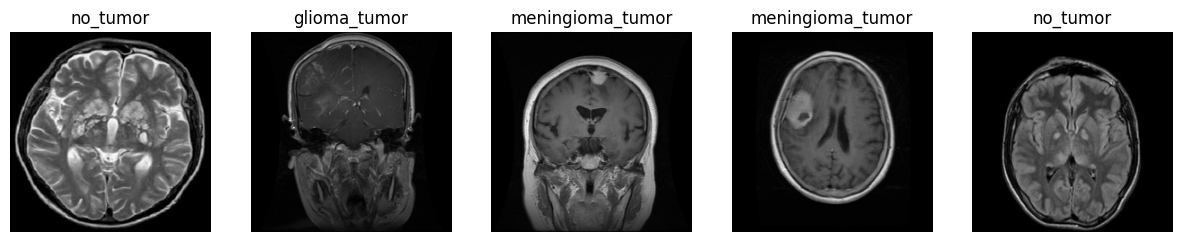

In [5]:
plt.figure(figsize=(15, 3))
for i in range(5):
    plt.subplot(1, 5, i + 1)
    plt.imshow(x_ds[i])
    plt.title(y_ds[i])
    plt.axis('off')
plt.show()

I've split the dataset into Training, Validation and Test subsets with 81%-9%-10% ratio.

In [5]:
x_train,x_test, y_train,y_test = train_test_split(x_ds,y_ds_onehot, test_size=0.1,random_state=2023)
x_train,x_valid, y_train,y_valid = train_test_split(x_train,y_train, test_size=0.1,random_state=2023)

print(f"Number of Training Images: {len(x_train)}")
print(f"Number of Validation Images: {len(x_valid)}")
print(f"Number of Test Images: {len(x_test)}")

Number of Training Images: 2643
Number of Validation Images: 294
Number of Test Images: 327


### I have used the same model that I have talked about above.

In [22]:
def lr_schedule(epoch):
    if epoch < 3:
        return 0.001
    elif 3 <= epoch < 6:
        return 0.0005
    else:
        return 0.0001
lr_scheduler = LearningRateScheduler(lr_schedule)   


base_efficientnet_model = EfficientNetB3(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
#base_efficientnet_model.trainable = False

efficientnet_model = Sequential([
    base_efficientnet_model,
    layers.Dropout(0.5),
    layers.Flatten(),
    layers.Dropout(0.5),
    layers.Dense(4, activation='softmax')
])

efficientnet_model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

efficientnet_model.summary()

checkpoint = ModelCheckpoint("efficientB3_model_Adam.hdf5", monitor='val_loss', mode='min', save_best_only=True, verbose=1)

history = efficientnet_model.fit(x_train,y_train,validation_data = (x_valid, y_valid), epochs = 10, verbose=1, batch_size=32,
                   callbacks=[checkpoint, lr_scheduler])

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb3 (Functional  (None, 7, 7, 1536)        10783535  
 )                                                               
                                                                 
 dropout_14 (Dropout)        (None, 7, 7, 1536)        0         
                                                                 
 flatten_8 (Flatten)         (None, 75264)             0         
                                                                 
 dropout_15 (Dropout)        (None, 75264)             0         
                                                                 
 dense_8 (Dense)             (None, 4)                 301060    
                                                                 
Total params: 11084595 (42.28 MB)
Trainable params: 10997292 (41.95 MB)
Non-trainable params: 87303 (341.03 KB)
________

2024-01-11 11:38:56.411267: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_8/efficientnetb3/block1b_drop/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


83/83 [==============================] - ETA: 0s - loss: 1.1239 - accuracy: 0.7420
Epoch 1: val_loss improved from inf to 4.57964, saving model to efficientB3_model_Adam.hdf5


/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


83/83 [==============================] - 107s 557ms/step - loss: 1.1239 - accuracy: 0.7420 - val_loss: 4.5796 - val_accuracy: 0.7755 - lr: 0.0010
Epoch 2/10
83/83 [==============================] - ETA: 0s - loss: 0.7219 - accuracy: 0.8505
Epoch 2: val_loss improved from 4.57964 to 1.91606, saving model to efficientB3_model_Adam.hdf5
83/83 [==============================] - 43s 518ms/step - loss: 0.7219 - accuracy: 0.8505 - val_loss: 1.9161 - val_accuracy: 0.8401 - lr: 0.0010
Epoch 3/10
83/83 [==============================] - ETA: 0s - loss: 0.6181 - accuracy: 0.8854
Epoch 3: val_loss improved from 1.91606 to 0.48943, saving model to efficientB3_model_Adam.hdf5
83/83 [==============================] - 43s 521ms/step - loss: 0.6181 - accuracy: 0.8854 - val_loss: 0.4894 - val_accuracy: 0.8878 - lr: 0.0010
Epoch 4/10
83/83 [==============================] - ETA: 0s - loss: 0.2863 - accuracy: 0.9376
Epoch 4: val_loss improved from 0.48943 to 0.21589, saving model to efficientB3_model_Adam

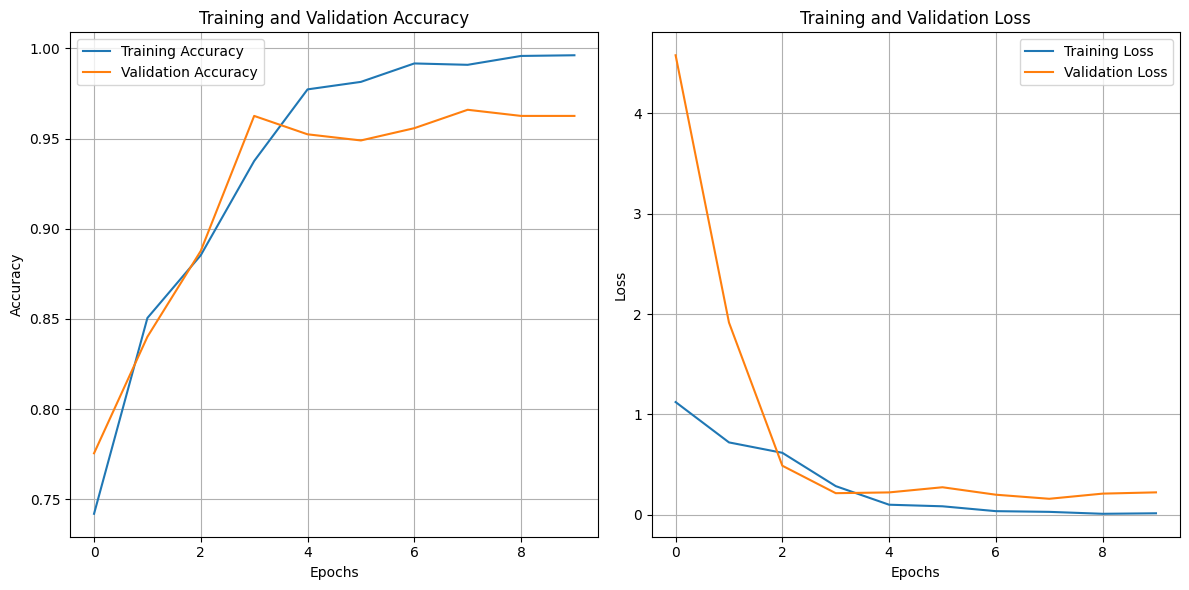

In [23]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))
axes[0].plot(history.history['accuracy'], label='Training Accuracy')
axes[0].plot(history.history['val_accuracy'], label='Validation Accuracy')
axes[0].set_title('Training and Validation Accuracy')
axes[0].set_xlabel('Epochs')
axes[0].set_ylabel('Accuracy')
axes[0].legend()
axes[0].grid(True)

axes[1].plot(history.history['loss'], label='Training Loss')
axes[1].plot(history.history['val_loss'], label='Validation Loss')
axes[1].set_title('Training and Validation Loss')
axes[1].set_xlabel('Epochs')
axes[1].set_ylabel('Loss')
axes[1].legend()
axes[1].grid(True)

plt.tight_layout()
plt.show()

In [24]:
loaded_efficientnet_model = tf.keras.models.load_model("efficientB3_model_Adam.hdf5")

efficient_predictions = loaded_efficientnet_model.predict(x_test)

print(classification_report(np.argmax(y_test, axis=1), np.argmax(efficient_predictions, axis=1)))

11/11 [==============================] - 3s 111ms/step
              precision    recall  f1-score   support

           0       0.97      0.93      0.95        92
           1       0.94      0.93      0.94        90
           2       0.90      0.98      0.94        57
           3       1.00      0.99      0.99        88

    accuracy                           0.96       327
   macro avg       0.95      0.96      0.96       327
weighted avg       0.96      0.96      0.96       327



After loading in (unecessary right after the training, we can simply just use the model), we get the evaluation for our test data. 
It's performance is a nice ~96% accuracy.
### Here we check the predicted result of the model. 
### **E** = *Expected*
### **P** = *Predicted*

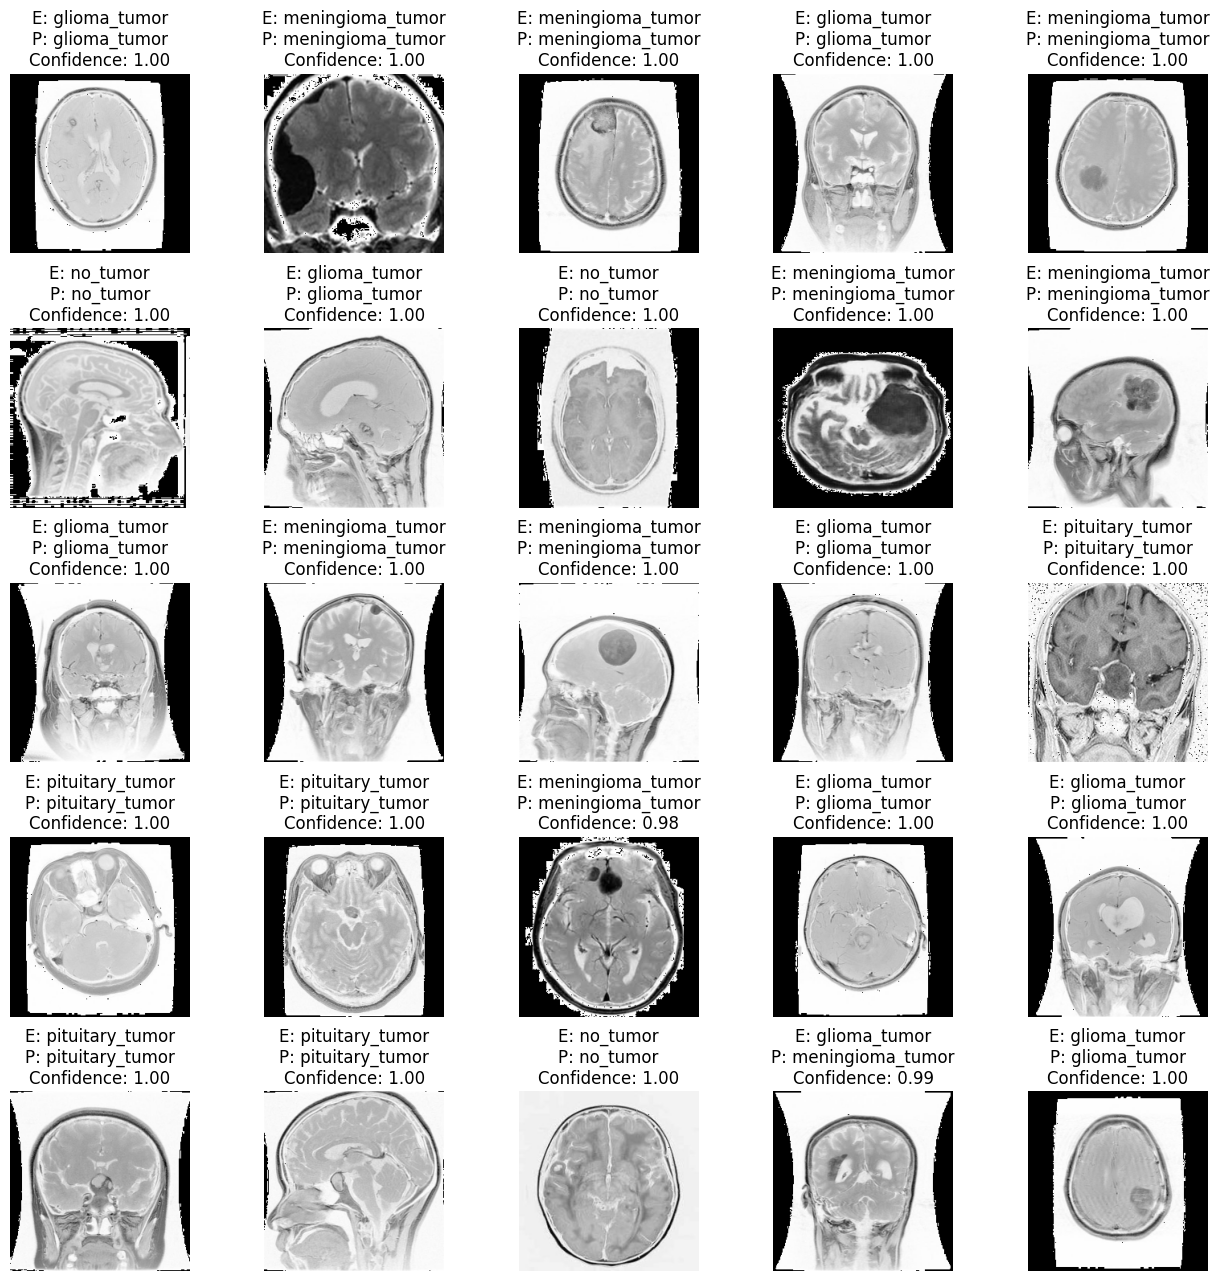

In [25]:
fig, axs = plt.subplots(5, 5)
fig.set_figwidth(13)
fig.set_figheight(13)
fig.tight_layout(pad=2)

for i in range(25):
    row, col = divmod(i, 5)
    class_index = np.argmax(efficient_predictions[i])
    confidence_value = efficient_predictions[i][class_index]
    
    axs[row, col].title.set_text(f"E: {labels[np.argmax(y_test[i])]}\nP: {labels[class_index]}\nConfidence: {confidence_value:.2f}")
    axs[row, col].imshow(np.clip(x_test[i] * 255, 0, 255).astype('uint8'))
    axs[row, col].axis('off')

plt.show()

### As we can see, the model hardly ever makes a mistake in the diagnosis (and it does make assumptions with very high confidence), so in order to see the possible misclassifications, we'll need a confusion matrix (for that I have used seaborn as we have used it in a previous lecture).

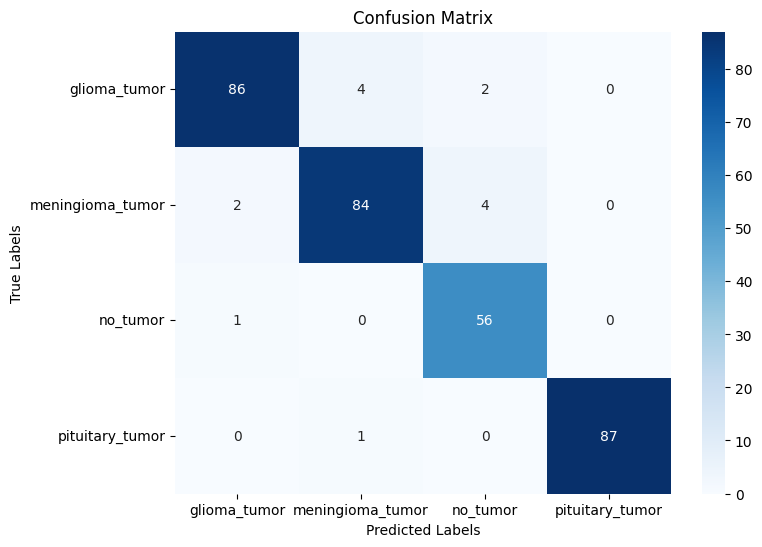

In [26]:

y_true = np.argmax(y_test, axis=1)
y_pred = np.argmax(efficient_predictions, axis=1)

conf_matrix = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

### As we can see, the Meningioma tumor was misclassified as healthy and as Glioma. After that, the Glioma had 6 misclassifications aswell. The model mainly has confused it with Meningioma and with no tumor. Overall, I think it is a good performance for such simple model as this is.

# Conclusion
#### It was really interesting to work on a project that is about a subject which is very far away from our field (computer science vs healthcare) and how we can combine the best of them. By using a lot of things we have discussed during our lectures (fine tuning hyperparameters, monitoring them, crossvalidation, different visualizations and searching after the best configurations) I was able to create a well trained model which is able to generalize on unseen data very accurately. Although for some reason I was not able to use Data Augmentation due to some bug, which probably would have been able to further improve the performance of the model, I have gained so much experience trying to solve the problems, finding workarounds. All in all, I think this project well represents the knowledge I have gained during this semester's lectures, and I have greatly appreciated the guidance and support provided by my teacher throughout this challenging and rewarding journey.